# Mark's Notebook

## Imports

In [734]:
import cv2
import numpy as np
import os
import math
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from scripts.utils import *
from scripts.edges import *

## Loading an image to work with

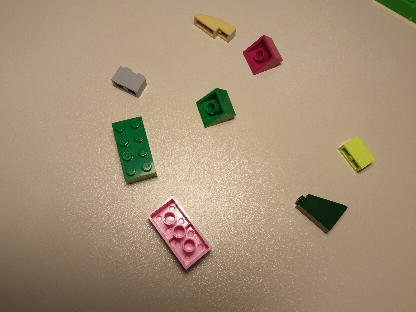

In [735]:
img = loadImage(11)

render(img)

In [736]:
#convert img to rgb from bgr
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


## Investigation

In [737]:
""" # Get the histogram of the image

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Calculate the histogram
hist = cv2.calcHist([gray], [0], None, [256], [0, 256])

# Plot the histogram
plt.plot(hist)
plt.xlim([0, 256])
plt.show()

render(gray)
 """;

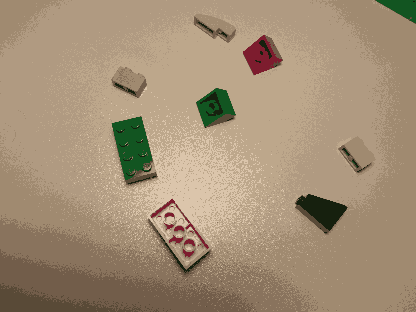

In [738]:
# Apply k-means clustering to segment the image

blurred = cv2.GaussianBlur(img, (3, 3), 0)

# Convert the image to a 2D array of pixels
pixels = img.reshape((-1, 3))
pixels = np.float32(pixels)

# Define the criteria, number of clusters and apply k-means
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 1.0)
num_clusters = 10 # Adjust based on the number of colors you want
_, labels, centers = cv2.kmeans(pixels, num_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Convert back to 8 bit values
centers = np.uint8(centers)

# Map the labels to the centers
segmented_data = centers[labels.flatten()]

# Reshape the data into the original image
segmented_image = segmented_data.reshape((img.shape))

render(segmented_image)

In [739]:
""" # Smooth the image using Gaussian blur
blurred = cv2.GaussianBlur(img, (23, 23), 0)

# Convert the image from BGR to RGB
image_rgb = cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB)

# Reshape the image into a 2D array of pixels
pixels = image_rgb.reshape((-1, 3))

# Use KMeans to perform color quantization
kmeans = KMeans(n_clusters=10)  # Adjust the number of clusters as needed
kmeans.fit(pixels)

# Get the cluster centers and labels
colors = kmeans.cluster_centers_
labels = kmeans.labels_

# Get the counts of each label
label_counts = np.bincount(labels)

# Get the index of the most common color (excluding background)
background_label = np.argmax(label_counts)
common_color_index = np.argmax(np.delete(label_counts, background_label))

# Get the most common color
common_color = colors[common_color_index].astype(int)

# Threshold to separate background and foreground
threshold = 30  # Adjust as needed
background_mask = np.all(np.abs(colors - common_color) < threshold, axis=1)

# Remove background pixels
masked_labels = labels.reshape(image_rgb.shape[:2])
masked_labels[background_mask[masked_labels]] = background_label
image_rgb[masked_labels == background_label] = [0, 0, 0]  # Set background pixels to black

render(image_rgb) """;

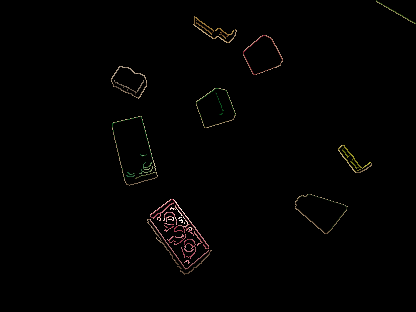

In [740]:
# Use the Canny edge detector to detect edges

# Convert the image to grayscale
gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)

# Apply Canny edge detection
edges = cv2.Canny(gray, 100, 200)

# Create a mask for the edges
edge_mask = np.zeros_like(img)

# Set the edge pixels to white
edge_mask[edges > 0] = (255, 255, 255)

# Apply the mask to the original image
edge_image = cv2.bitwise_and(img, edge_mask)

render(edge_image)

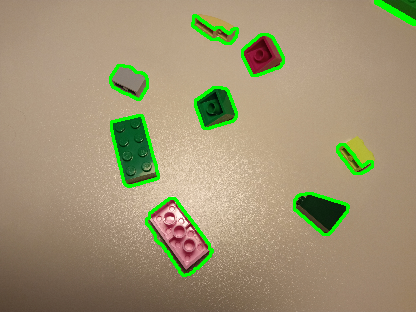

In [741]:
# Find contours in the edge image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a kernel for dilation
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))  # Adjust kernel size as needed

# Dilate the edge image
dilated_edges = cv2.dilate(edges, kernel)

# Find contours in the dilated image
contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on a copy of the original image
contour_image = img.copy()

cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

# Display or save the resulting image
render(contour_image)

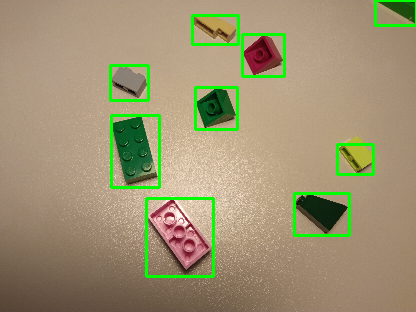

Number of Lego pieces: 9


In [742]:
num_legos = 0

# Define area threshold for bounding rectangles
area_threshold = 200  # Adjust as needed
intersection_threshold = 0.25

# Create a copy of the original image for drawing bounding boxes
bounding_box_image = img.copy()

# List to store bounding rectangles of drawn legos
bounding_rectangles = []

# Iterate through contours
for contour in contours:
    # Get the bounding box of the contour
    x, y, w, h = cv2.boundingRect(contour)
    
    # Calculate the area of the bounding rectangle
    area = w * h
    
    # Check if area is above the threshold
    if area > area_threshold:
        # Check if this bounding rectangle overlaps with any previously drawn ones
        overlap = False
        contained = False
        for (bx, by, bw, bh) in bounding_rectangles:
            intersection_area = max(0, min(x+w, bx+bw) - max(x, bx)) * max(0, min(y+h, by+bh) - max(y, by))
            union_area = area + bw*bh - intersection_area
            if intersection_area / union_area > intersection_threshold:
                overlap = True
                # print("OVERLAP")
                break
            if x >= bx and y >= by and x + w <= bx + bw and y + h <= by + bh:
                contained = True
                # print("CONTAINED")
                break
        
        # If not fully contained and no significant overlap, draw the bounding box and increment lego count
        if not contained and not overlap:
            cv2.rectangle(bounding_box_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            bounding_rectangles.append((x, y, w, h))
            num_legos += 1
        
# Display the image with bounding boxes
render(bounding_box_image)

# Print the number of legos
print("Number of Lego pieces:", num_legos)


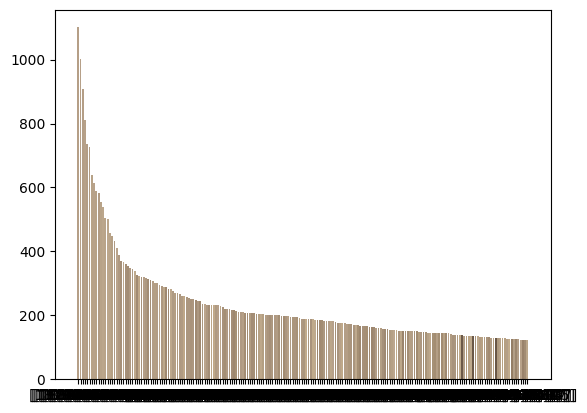

In [743]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# Convert the image to bgr
bgr = cv2.cvtColor(blurred, cv2.COLOR_RGB2BGR)

# Reshape the image to be a list of pixels
pixels = bgr.reshape(-1, 3)

# Convert pixels to tuples
pixel_tuples = [tuple(pixel) for pixel in pixels]

# Count the frequency of each color
color_counter = Counter(pixel_tuples)

# Get the 10 most common colors
most_common_colors = color_counter.most_common(200)

# Separate colors and their counts
colors, counts = zip(*most_common_colors)

# Convert colors to numpy arrays for plotting
colors = np.array(colors)

# Plot histogram
plt.bar(range(len(colors)), counts, color=colors/255)
plt.xticks(range(len(colors)), colors)
plt.show()


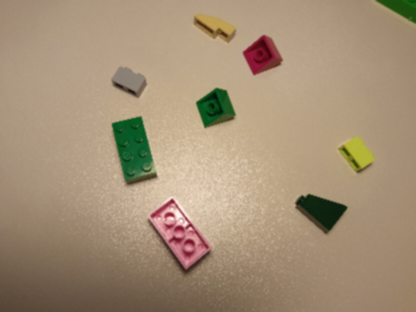

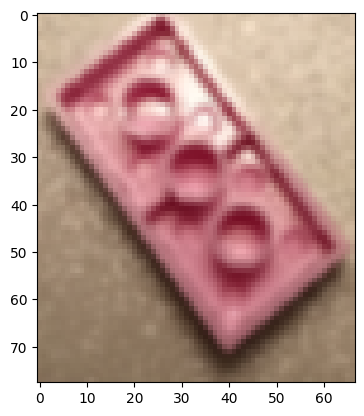

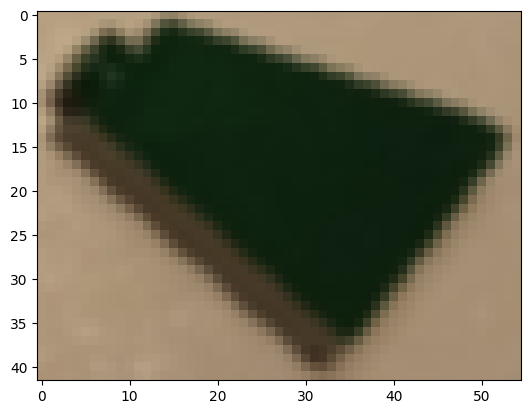

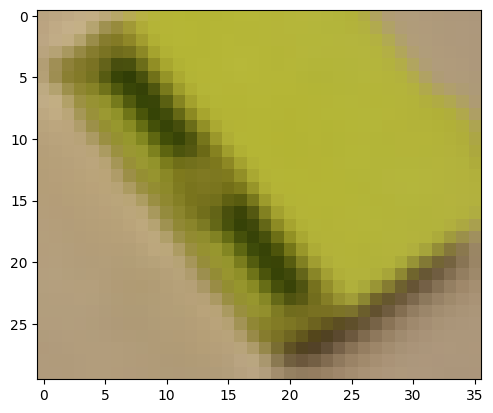

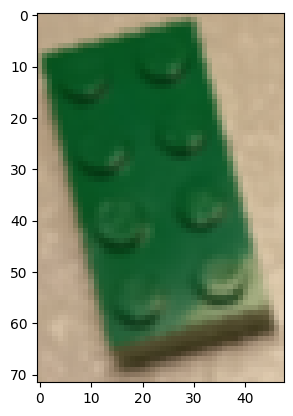

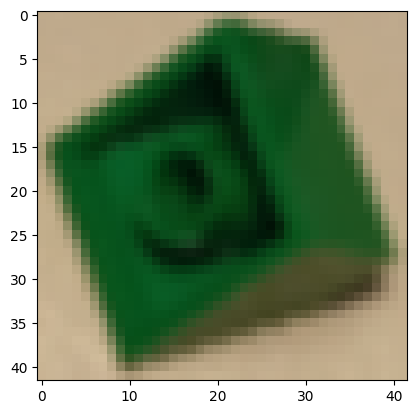

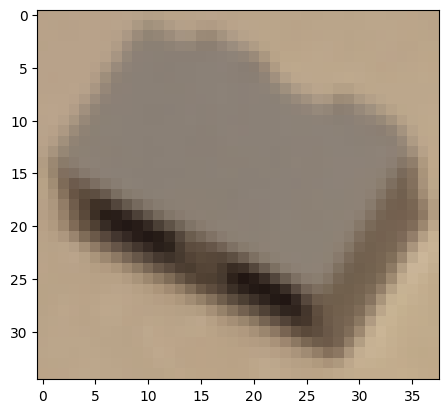

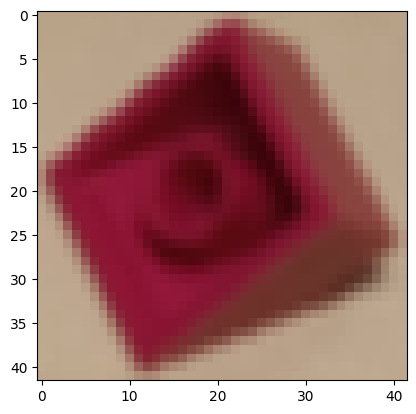

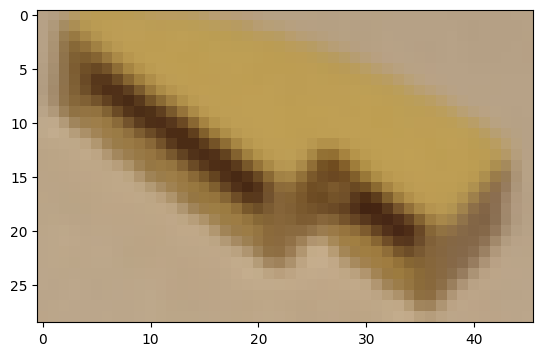

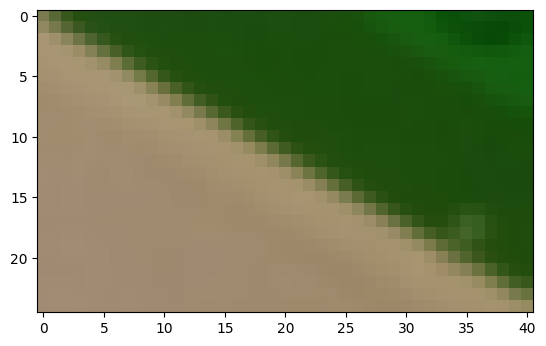

In [744]:
import matplotlib.pyplot as plt

render(blurred)

# Convert the image to bgr
bgr = cv2.cvtColor(blurred, cv2.COLOR_RGB2BGR)

cropped_images = []

# For each bounding rectangle, display the image it contains
for rect in bounding_rectangles:
    x, y, w, h = rect
    cropped_image = bgr[y:y+h, x:x+w]
    cropped_images.append(cropped_image)
    plt.imshow(cropped_image)
    plt.show()


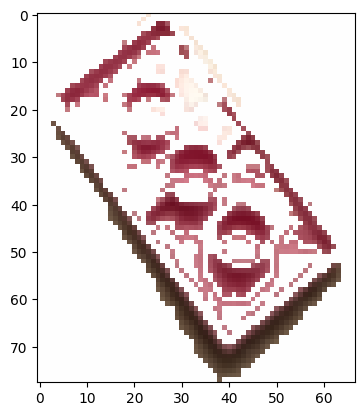

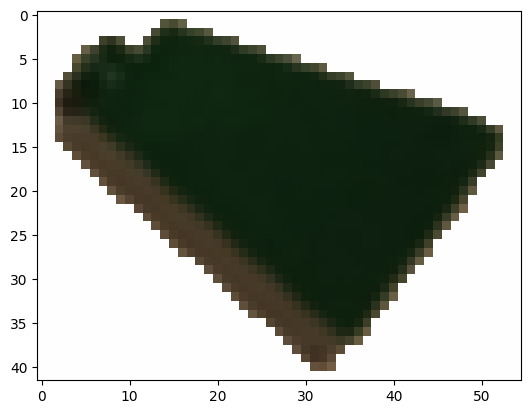

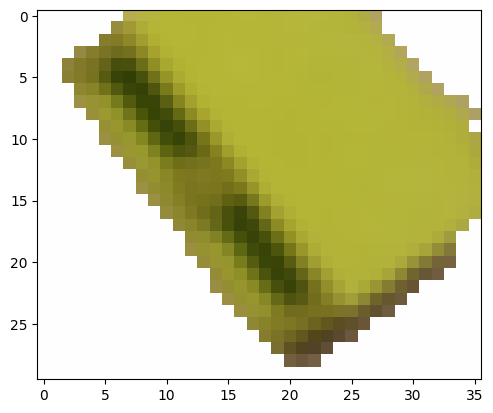

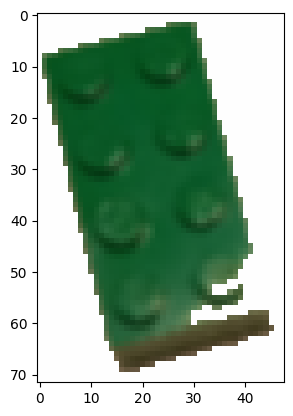

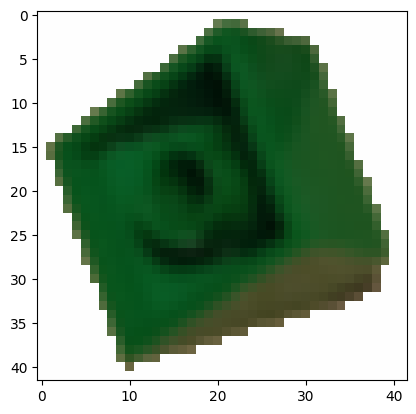

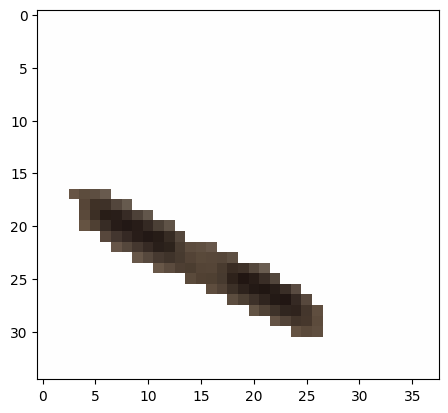

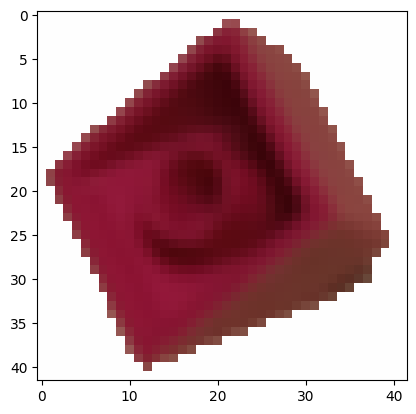

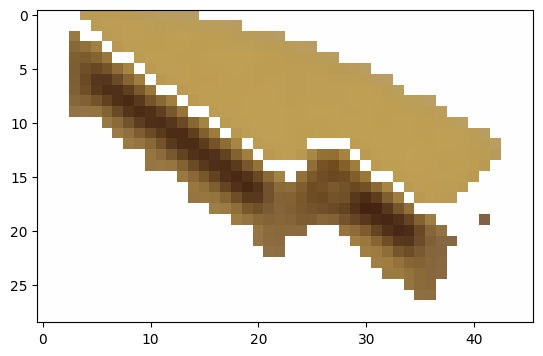

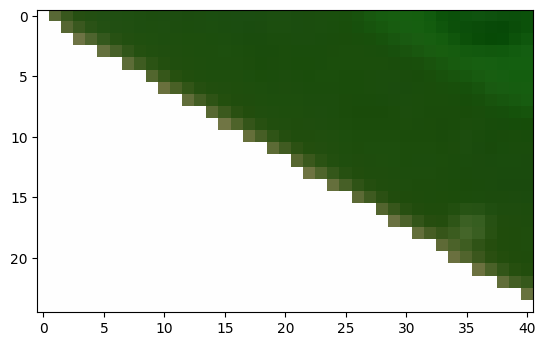

In [745]:
import cv2
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

def remove_similar_colors(cropped_images, most_common_colors, threshold_distance):
    # Define a replacement color
    replacement_color = (254, 254, 254)  # You can choose any color you want

    # Iterate over each cropped image
    for index, cropped_image in enumerate(cropped_images):
        # Iterate over each pixel in the image
        for y in range(cropped_image.shape[0]):
            for x in range(cropped_image.shape[1]):
                # Calculate the distance between the pixel color and each of the most common colors
                distances = [np.linalg.norm(np.array(cropped_image[y, x]) - np.array(color)) for color in most_common_colors]
                
                # Check if any distance is less than the threshold
                if min(distances) < threshold_distance:
                    # Replace the pixel color with the replacement color
                    cropped_image[y, x] = replacement_color

        # Update the cropped image in the list
        cropped_images[index] = cropped_image

    return cropped_images

# Example usage:
# cropped_images is a list containing cropped images
# most_common_colors is a list of tuples containing the most common colors
# threshold_distance is the maximum allowed distance between colors to consider them similar
# You can obtain them using the code you provided earlier

# Call the function to remove similar colors to the most common colors from cropped images
threshold_distance = 100  # Adjust this threshold as needed
cropped_images_without_similar_colors = remove_similar_colors(cropped_images, colors, threshold_distance)

# Display the modified cropped images
for cropped_image in cropped_images_without_similar_colors:
    plt.imshow(cropped_image)
    plt.show()


In [746]:
def display_color_square(color):
    """
    Display a square of a specific color in RGB format.
    """
    # Convert color values to the range 0-1
    color = (color[0] / 255, color[1] / 255, color[2] / 255)

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Set axis limits
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    # Draw a rectangle with the specified color
    rectangle = plt.Rectangle((0.1, 0.1), 0.8, 0.8, color=color)
    ax.add_patch(rectangle)

    # Remove axis
    ax.axis('off')

    # Display the plot
    plt.show()

In [747]:
from sklearn.metrics import pairwise_distances_argmin

def name_color(rgb, color_dict):
    # Convert the RGB values to a 2D array
    rgb = np.array(rgb).reshape(1, -1)
    
    # Calculate the distance between the given color and all colors in the dictionary
    distances = pairwise_distances_argmin(rgb, list(color_dict.keys()))
    
    # Find the color with the smallest distance
    closest_color = list(color_dict.keys())[distances[0]]
    
    # Return the name of the closest color
    return color_dict[closest_color]

# Define a dictionary of common color names and their RGB values

color_dict = {
    (255, 0, 0): 'Red',
    (0, 255, 0): 'Green',
    (0, 0, 255): 'Blue',
    (255, 255, 255): 'White',
    (0, 0, 0): 'Black',
    (255, 255, 0): 'Yellow',
    (0, 255, 255): 'Cyan',
    (255, 0, 255): 'Magenta',
    (128, 0, 0): 'Maroon',
    (128, 128, 0): 'Olive',
    (0, 128, 0): 'Green',
    (128, 0, 128): 'Purple',
    (0, 128, 128): 'Teal',
    (128, 128, 128): 'Gray',
    (192, 192, 192): 'Silver',
    (128, 128, 255): 'Light Blue',
    (128, 255, 128): 'Light Green',
    (255, 128, 128): 'Light Red',
    (255, 255, 128): 'Light Yellow',
    (255, 128, 255): 'Light Magenta',
    (128, 255, 255): 'Light Cyan',
    (0, 255, 128): 'Spring Green',
    (255, 128, 0): 'Orange',
    (255, 69, 0): 'Orange Red',
    (139, 69, 19): 'Saddle Brown',
    (218, 165, 32): 'Goldenrod',
    (218, 112, 214): 'Orchid',
    (106, 90, 205): 'Slate Blue',
    (0, 191, 255): 'Deep Sky Blue',
    (255, 20, 147): 'Deep Pink',
    (128, 0, 128): 'Purple',
    (255, 140, 0): 'Dark Orange',
    (255, 215, 0): 'Gold',
    (0, 128, 0): 'Green',
    (128, 128, 0): 'Olive',
    (255, 192, 203): 'Pink',
    (75, 0, 130): 'Indigo',
    (139, 0, 139): 'Dark Magenta',
    (0, 255, 127): 'Medium Spring Green',
    (255, 165, 0): 'Orange',
    (255, 99, 71): 'Tomato',
    (173, 255, 47): 'Green Yellow',
    (30, 144, 255): 'Dodger Blue',
    (255, 105, 180): 'Hot Pink',
    (0, 206, 209): 'Dark Turquoise',
    (154, 205, 50): 'Yellow Green',
    (0, 250, 154): 'Medium Spring Green',
    (128, 0, 0): 'Maroon',
    (165, 42, 42): 'Brown',
    (255, 0, 255): 'Fuchsia',
    (139, 69, 19): 'Saddle Brown',
    (189, 183, 107): 'Dark Khaki',
    (240, 128, 128): 'Light Coral',
    (255, 182, 193): 'Light Pink',
    (233, 150, 122): 'Dark Salmon',
    (255, 69, 0): 'Red Orange',
    (160, 82, 45): 'Sienna',
    (255, 140, 105): 'Light Salmon',
    (218, 112, 214): 'Pale Violet Red',
    (0, 255, 255): 'Aqua',
    (255, 255, 224): 'Light Yellow',
    (255, 228, 196): 'Bisque',
    (255, 192, 203): 'Pale Violet Red',
    (255, 127, 80): 'Coral',
    (240, 230, 140): 'Khaki',
    (0, 139, 139): 'Dark Cyan',
    (32, 178, 170): 'Light Sea Green',
    (135, 206, 250): 'Light Sky Blue',
    (123, 104, 238): 'Medium Slate Blue',
    (0, 128, 128): 'Teal',
    (216, 191, 216): 'Thistle',
    (244, 164, 96): 'Sandy Brown',
    (173, 255, 47): 'Green Yellow',
    (255, 215, 0): 'Gold',
    (255, 250, 205): 'Lemon Chiffon',
    (210, 180, 140): 'Tan',
    (152, 251, 152): 'Pale Green',
    (175, 238, 238): 'Pale Turquoise',
    (0, 255, 255): 'Aqua',
    (245, 245, 220): 'Beige',
    (0, 255, 127): 'Spring Green',
    (255, 99, 71): 'Tomato',
    (250, 128, 114): 'Salmon',
    (100, 149, 237): 'Cornflower Blue',
    (102, 205, 170): 'Medium Aquamarine',
    (255, 0, 127): 'Ruby',
    (0, 100, 0): 'Dark Green',
    (240, 248, 255): 'Alice Blue',
    (135, 206, 235): 'Sky Blue',
    (0, 0, 128): 'Navy',
    (173, 216, 230): 'Light Blue',
    (128, 128, 0): 'Olive',
    (255, 105, 180): 'Hot Pink',
    (0, 255, 0): 'Lime',
    (255, 0, 255): 'Magenta',
    (255, 255, 0): 'Yellow',
    (255, 192, 203): 'Pink',
    (255, 255, 255): 'White',
    (0, 0, 0): 'Black',
    (255, 69, 0): 'Red Orange',
    (255, 255, 224): 'Light Yellow',
    (240, 128, 128): 'Light Coral',
    (255, 160, 122): 'Light Salmon',
    (0, 128, 0): 'Green',
    (128, 128, 128): 'Gray',
    (255, 20, 147): 'Deep Pink'
}



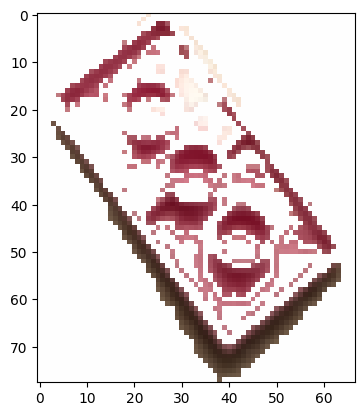

[82.44897959 58.36734694 46.97376093]
Saddle Brown


C:\Users\sanct\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


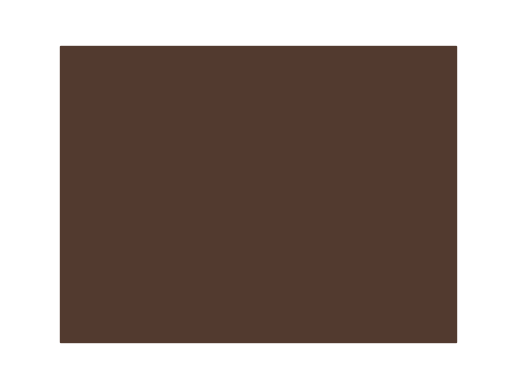

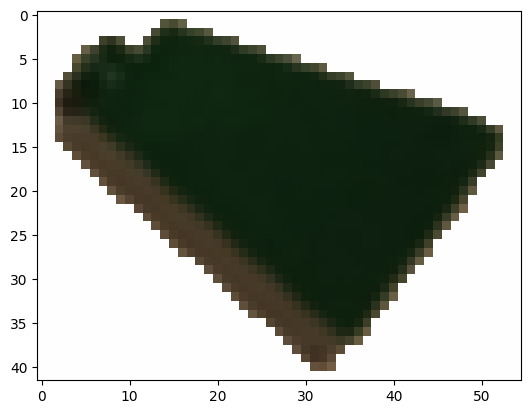

[13.9739777  33.92317224 15.0669145 ]
Black


C:\Users\sanct\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


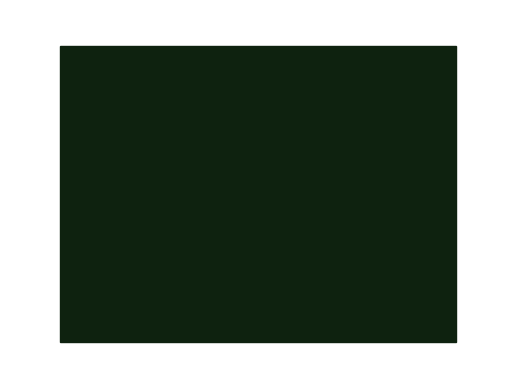

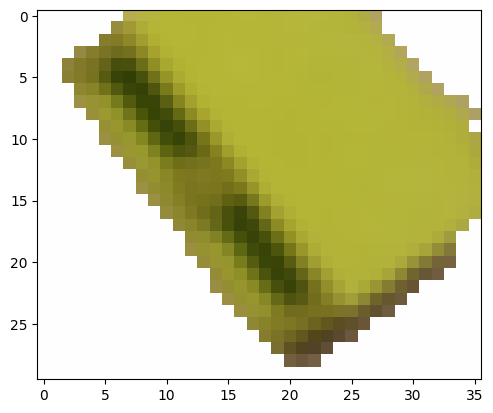

[178.85025381 178.91878173  57.35025381]
Yellow Green


C:\Users\sanct\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


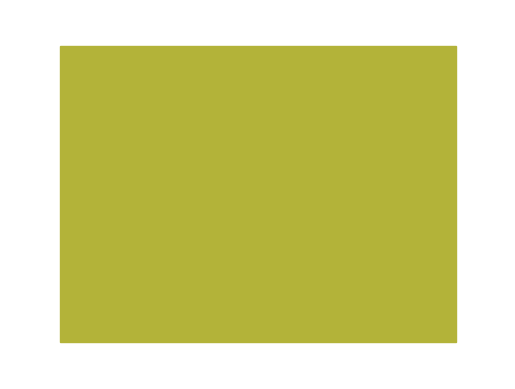

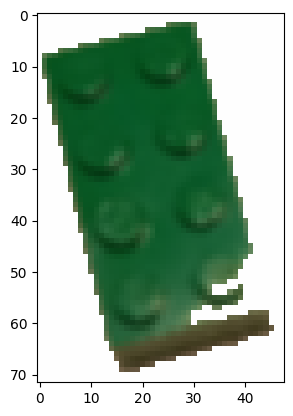

[12.34275618 86.64929329 37.95936396]
Dark Green


C:\Users\sanct\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


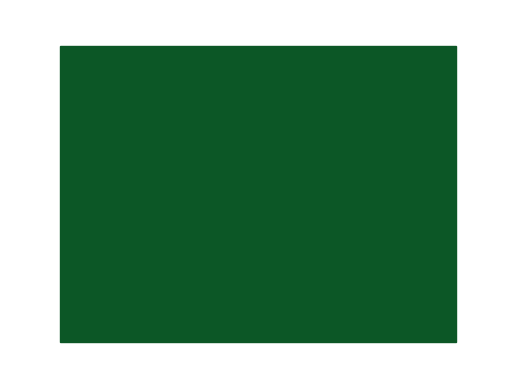

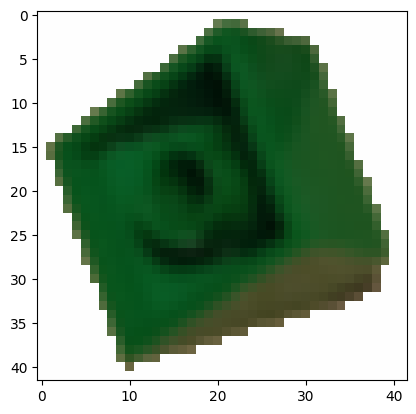

[ 9.49010989 78.32747253 27.63516484]
Dark Green


C:\Users\sanct\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


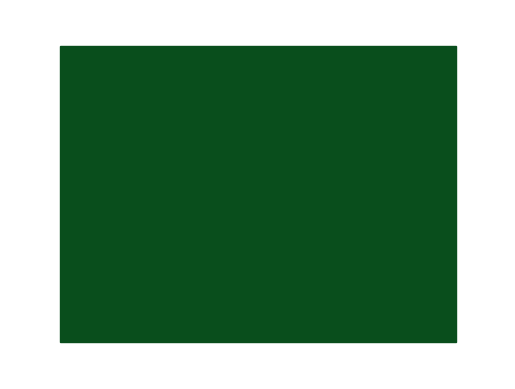

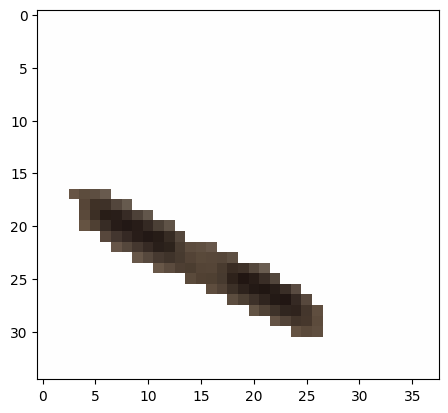

[83.97142857 69.14285714 56.62857143]
Saddle Brown


C:\Users\sanct\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


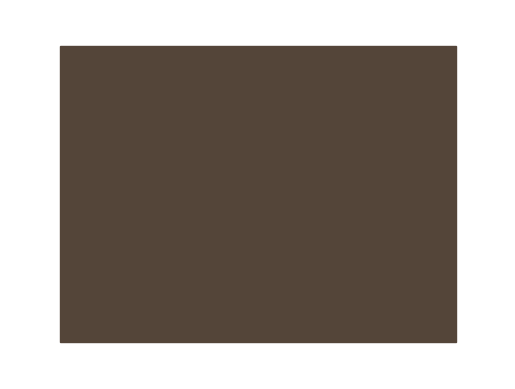

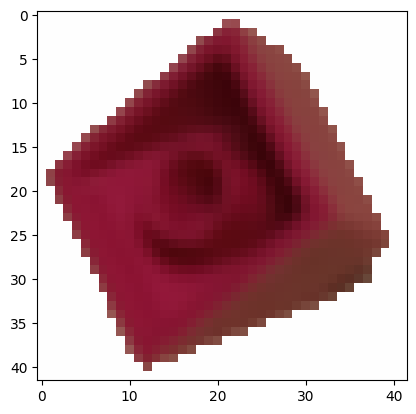

[131.0471464   22.99007444  47.86352357]
Brown


C:\Users\sanct\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


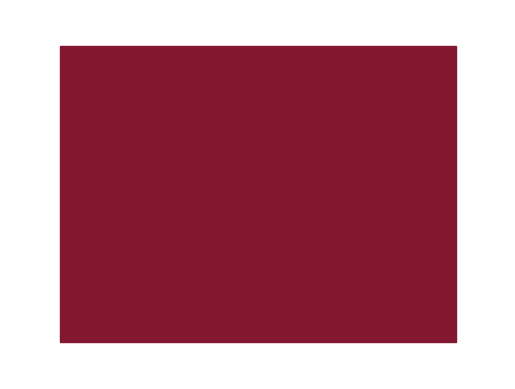

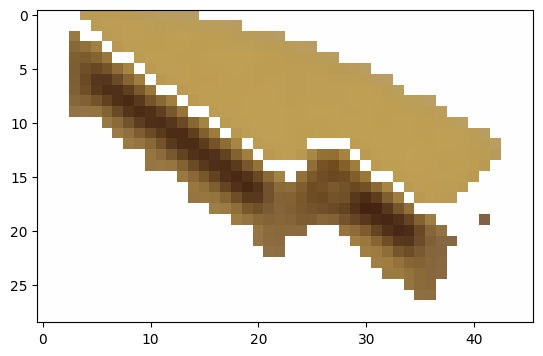

[188.71428571 157.42192691  84.54817276]
Dark Khaki


C:\Users\sanct\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


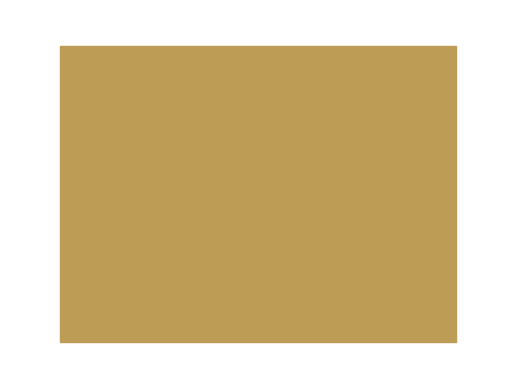

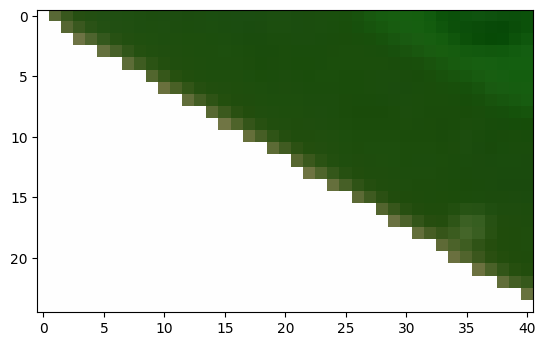

[28.85674931 77.26170799 13.14600551]
Dark Green


C:\Users\sanct\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


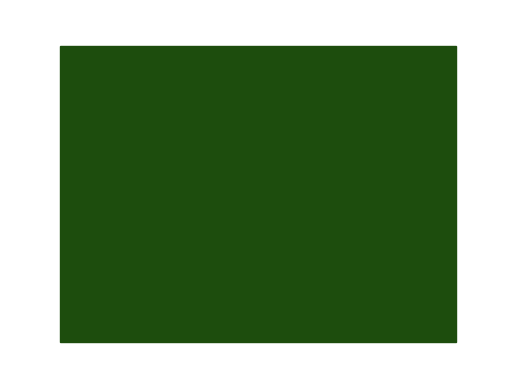

In [748]:
from sklearn.cluster import KMeans
import numpy as np
from collections import Counter

# List to store the most frequent colors of each cropped image
most_frequent_colors = []

most_frequent_colors.append((254., 254., 254.))  # Add black as a common color

# Define a threshold for color similarity
color_similarity_threshold = 1

# Function to calculate Euclidean distance between two colors
def color_distance(color1, color2):
    return np.sqrt(np.sum((color1 - color2) ** 2))

# Loop over each bounding rectangle
for cropped_img in cropped_images:

    # Reshape the image to be a list of pixels
    pixels = cropped_img.reshape(-1, 3)

    # display cropped image with plt
    plt.imshow(cropped_img)
    plt.show()


    # Perform KMeans to find the most dominant color
    kmeans = KMeans(n_clusters=5)
    kmeans.fit(pixels)

    # Get the RGB values of the cluster centers
    colors = kmeans.cluster_centers_

    # Count the occurrence of each color
    color_counter = Counter(kmeans.labels_)

    # Sort colors by occurrence
    sorted_colors = sorted(color_counter.items(), key=lambda x: x[1], reverse=True)

    #start most_freq_color
    most_freq_color = None

    # Find the most frequent color that isn't one of the previously found common colors
    for color_index, _ in sorted_colors:
        color = colors[color_index]
        if not any(color_distance(color, common_color) < color_similarity_threshold for common_color in most_frequent_colors):
            most_freq_color = color
            most_frequent_colors.append(color)
            break
    print(most_freq_color)

    # name the color
    print(name_color(most_freq_color, color_dict))
    
    display_color_square(most_freq_color)
